# Step 5: Advanced Modeling & Optimization

**Objective:** Train multiple regression models, tune hyperparameters,
compare via cross-validation, and select the best model.

---

## 5.1 Setup

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.models import train_model, tune_model, save_model_versioned
from src.evaluation import evaluate_model, print_metrics, cross_validate_model, build_comparison_table, select_best_model
from src.visualization import plot_actual_vs_predicted, plot_residuals

X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze()

print(f"Train: {X_train.shape}  |  Test: {X_test.shape}")

Train: (45600, 76)  |  Test: (11400, 76)


## 5.2 Train Multiple Models

In [2]:
model_names = ["linear_regression", "ridge", "lasso", "decision_tree", "random_forest", "gradient_boosting"]

trained_models = {}
results = {}

for name in model_names:
    print(f"\n{'='*40}")
    model = train_model(name, X_train, y_train)
    metrics = evaluate_model(model, X_test, y_test)
    print_metrics(metrics)
    trained_models[name] = model
    results[name] = metrics

Trained: linear_regression (LinearRegression)
  R²   = 0.8935
  MAE  = 0.35
  RMSE = 0.46

Trained: ridge (Ridge)
  R²   = 0.8935
  MAE  = 0.35
  RMSE = 0.46



Trained: lasso (Lasso)
  R²   = 0.8931
  MAE  = 0.35
  RMSE = 0.46



Trained: decision_tree (DecisionTreeRegressor)
  R²   = 0.7780
  MAE  = 0.48
  RMSE = 0.66



Trained: random_forest (RandomForestRegressor)


  R²   = 0.8869
  MAE  = 0.36
  RMSE = 0.47



Trained: gradient_boosting (GradientBoostingRegressor)
  R²   = 0.8731
  MAE  = 0.40
  RMSE = 0.50


In [3]:
# XGBoost (advanced)
try:
    xgb_model = train_model("xgboost", X_train, y_train)
    xgb_metrics = evaluate_model(xgb_model, X_test, y_test)
    print_metrics(xgb_metrics)
    trained_models["xgboost"] = xgb_model
    results["xgboost"] = xgb_metrics
except ImportError:
    print("XGBoost not installed — skipping.")

Trained: xgboost (XGBRegressor)
  R²   = 0.8903
  MAE  = 0.36
  RMSE = 0.47


## 5.3 Initial Comparison

In [4]:
comparison_df = build_comparison_table(results)
comparison_df

,Model,R²,MAE,RMSE
0,linear_regression,0.8935,0.35,0.46
1,ridge,0.8935,0.35,0.46
2,lasso,0.8931,0.35,0.46
3,xgboost,0.8903,0.36,0.47
4,random_forest,0.8869,0.36,0.47
5,gradient_boosting,0.8731,0.40,0.50
6,decision_tree,0.7780,0.48,0.66


## 5.4 Hyperparameter Tuning

Tune 2 performing models using RandomizedSearchCV.

In [5]:
# Tune Random Forest
print("Tuning Random Forest...")
best_rf = tune_model("random_forest", X_train, y_train, cv=3, n_iter=10)
rf_tuned_metrics = evaluate_model(best_rf, X_test, y_test)
print("\nTuned Random Forest:")
print_metrics(rf_tuned_metrics)
trained_models["random_forest_tuned"] = best_rf
results["random_forest_tuned"] = rf_tuned_metrics

Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best params for random_forest: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best CV r2: 0.8917

Tuned Random Forest:
  R²   = 0.8930
  MAE  = 0.35
  RMSE = 0.46


In [6]:
# Tune XGBoost 
if "xgboost" in trained_models:
    print("Tuning XGBoost...")
    best_xgb = tune_model("xgboost", X_train, y_train, cv=3, n_iter=10)
    xgb_tuned_metrics = evaluate_model(best_xgb, X_test, y_test)
    print("\nTuned XGBoost:")
    print_metrics(xgb_tuned_metrics)
    trained_models["xgboost_tuned"] = best_xgb
    results["xgboost_tuned"] = xgb_tuned_metrics

Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best params for xgboost: {'subsample': 0.7, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.2}
Best CV r2: 0.8923

Tuned XGBoost:
  R²   = 0.8932
  MAE  = 0.35
  RMSE = 0.46


## 5.5 Cross-Validation

In [7]:
print("Cross-validation scores (R²):\n")
cv_results = {}
for name in ["ridge", "random_forest"]:
    print(f"{name}:")
    cv_results[name] = cross_validate_model(trained_models[name], X_train, y_train, cv=5)
    print()

Cross-validation scores (R²):

ridge:


  CV r2 = 0.8927 ± 0.0018  (k=5)

random_forest:


  CV r2 = 0.8858 ± 0.0018  (k=5)



## 5.6 Final Comparison Table

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

final_comparison = build_comparison_table(results)

# Add BDT-scale columns (inverse log1p)
y_bdt = np.expm1(y_test)
bdt_rows = {}
for name, m in results.items():
    preds_bdt = np.maximum(np.expm1(m["predictions"]), 0)
    bdt_rows[name] = {
        "MAE (BDT)":  round(mean_absolute_error(y_bdt, preds_bdt), 2),
        "RMSE (BDT)": round(np.sqrt(mean_squared_error(y_bdt, preds_bdt)), 2),
    }

bdt_df = pd.DataFrame(bdt_rows).T.reset_index().rename(columns={"index": "Model"})
final_comparison = final_comparison.merge(bdt_df, on="Model")

print("\n=== Final Model Comparison ===")
final_comparison


=== Final Model Comparison ===


,Model,R²,MAE,RMSE,MAE (BDT),RMSE (BDT)
0,linear_regression,0.8935,0.35,0.46,28525.40,48259.86
1,ridge,0.8935,0.35,0.46,28527.35,48266.79
2,xgboost_tuned,0.8932,0.35,0.46,28687.71,48487.08
3,lasso,0.8931,0.35,0.46,28664.63,48628.66
4,random_forest_tuned,0.8930,0.35,0.46,28571.86,48133.46
5,xgboost,0.8903,0.36,0.47,28835.27,48742.29
6,random_forest,0.8869,0.36,0.47,29189.25,49598.49
7,gradient_boosting,0.8731,0.40,0.50,30976.09,54619.30
8,decision_tree,0.7780,0.48,0.66,37662.28,66051.74


## 5.7 Regularization & Bias-Variance Tradeoff

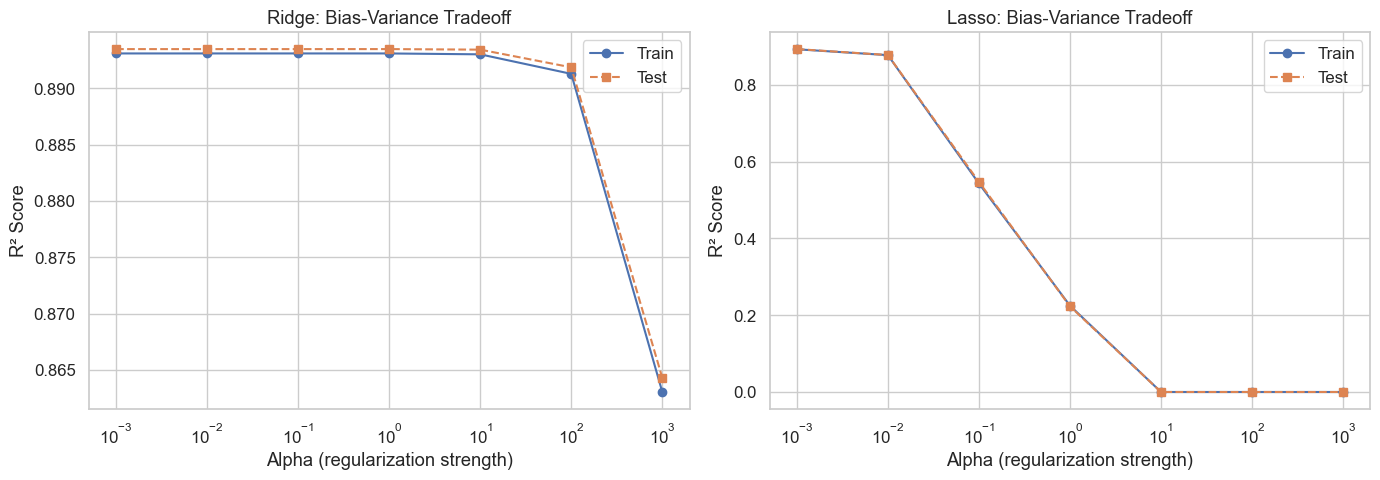

In [9]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

ridge_train_scores, ridge_test_scores = [], []
lasso_train_scores, lasso_test_scores = [], []

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    ridge_train_scores.append(r2_score(y_train, ridge.predict(X_train)))
    ridge_test_scores.append(r2_score(y_test, ridge.predict(X_test)))
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000).fit(X_train, y_train)
    lasso_train_scores.append(r2_score(y_train, lasso.predict(X_train)))
    lasso_test_scores.append(r2_score(y_test, lasso.predict(X_test)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogx(alphas, ridge_train_scores, "o-", label="Train")
axes[0].semilogx(alphas, ridge_test_scores, "s--", label="Test")
axes[0].set_title("Ridge: Bias-Variance Tradeoff")
axes[0].set_xlabel("Alpha (regularization strength)")
axes[0].set_ylabel("R² Score")
axes[0].legend()

axes[1].semilogx(alphas, lasso_train_scores, "o-", label="Train")
axes[1].semilogx(alphas, lasso_test_scores, "s--", label="Test")
axes[1].set_title("Lasso: Bias-Variance Tradeoff")
axes[1].set_xlabel("Alpha (regularization strength)")
axes[1].set_ylabel("R² Score")
axes[1].legend()

fig.tight_layout()
fig.savefig("../reports/figures/bias_variance_tradeoff.png", dpi=150, bbox_inches="tight")
plt.show()

## 5.8 Select & Save Best Model

In [10]:
import json
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load baseline metrics for comparison
baseline_path = Path("../data/processed/baseline_metrics.json")
baseline = json.loads(baseline_path.read_text()) if baseline_path.exists() else {}
baseline_mae_bdt = baseline.get("mae_bdt", None)

# BDT-scale metrics for all models
y_bdt = np.expm1(y_test)
bdt_results = {}
for name, m in results.items():
    preds_bdt = np.maximum(np.expm1(m["predictions"]), 0)
    bdt_results[name] = {
        "r2":  r2_score(y_bdt, preds_bdt),
        "mae": mean_absolute_error(y_bdt, preds_bdt),
        "rmse": np.sqrt(mean_squared_error(y_bdt, preds_bdt)),
    }

# Build final comparison table with BDT columns
final_comparison = build_comparison_table(results)
final_comparison["MAE (BDT)"]  = final_comparison["Model"].map({n: round(r["mae"], 2) for n, r in bdt_results.items()})
final_comparison["RMSE (BDT)"] = final_comparison["Model"].map({n: round(r["rmse"], 2) for n, r in bdt_results.items()})

# Cross-validate key models
print("Cross-validation scores (R²):\n")
cv_results = {}
for name in ["ridge", "random_forest_tuned", "xgboost_tuned"]:
    if name in trained_models:
        print(f"{name}:")
        cv_results[name] = cross_validate_model(trained_models[name], X_train, y_train, cv=5)
        print()

# Dynamic model selection — primary: lowest BDT MAE
best_name, criterion = select_best_model(final_comparison)
best_row = final_comparison[final_comparison["Model"] == best_name].iloc[0]
print(f"\nBest model selected : {best_name}")
print(f"Selection criterion : {criterion}")

# Save with versioning + registry
best_metrics = {
    "r2_log":  float(best_row["R²"]),
    "mae_log": float(best_row["MAE"]),
    "rmse_log": float(best_row["RMSE"]),
    "r2_bdt":  round(bdt_results[best_name]["r2"], 4),
    "mae_bdt": round(bdt_results[best_name]["mae"], 2),
    "rmse_bdt": round(bdt_results[best_name]["rmse"], 2),
    "selection_criterion": criterion,
    "selected_model_name": best_name,
}
save_model_versioned(trained_models[best_name], model_name="best_model", metrics=best_metrics, models_dir="../models")

Cross-validation scores (R²):

ridge:


  CV r2 = 0.8927 ± 0.0018  (k=5)

random_forest_tuned:


  CV r2 = 0.8920 ± 0.0019  (k=5)

xgboost_tuned:


  CV r2 = 0.8928 ± 0.0018  (k=5)


Best model selected : linear_regression
Selection criterion : BDT MAE (lowest)
Model saved (versioned)  -> ..\models\best_model_v20260228_211631.joblib
Model saved (canonical)  -> ..\models\best_model.joblib
Registry updated         -> ..\models\model_registry.json


In [11]:
print("=" * 70)
print("PHASE 5 ADVANCED MODELING SUMMARY")
print("=" * 70)
print()
display_df = final_comparison.sort_values("MAE (BDT)").reset_index(drop=True)
display_df.index += 1
print("Final Model Comparison (sorted by BDT MAE - lower is better):")
print()
print(display_df.to_string())
print()
best_mae_bdt  = bdt_results[best_name]["mae"]
best_rmse_bdt = bdt_results[best_name]["rmse"]
best_r2_log   = float(best_row["R²"])
best_r2_bdt   = bdt_results[best_name]["r2"]
print("-" * 50)
print(f"Best model selected : {best_name}")
print(f"Selection criterion : {criterion}")
print()
print("Best model metrics:")
print(f"  Log-scale R2  = {best_r2_log:.4f}")
print(f"  BDT-scale R2  = {best_r2_bdt:.4f}")
print(f"  BDT MAE       = {best_mae_bdt:,.0f} BDT")
print(f"  BDT RMSE      = {best_rmse_bdt:,.0f} BDT")
print()
if baseline_mae_bdt:
    pct_change = (best_mae_bdt - baseline_mae_bdt) / baseline_mae_bdt * 100
    print("Improvement vs Phase 4 baseline:")
    print(f"  BDT MAE: {baseline_mae_bdt:,.0f} -> {best_mae_bdt:,.0f} BDT ({pct_change:+.1f}%)")
    print()
print("Files saved:")
print("  models/best_model.joblib")
print("  models/best_model_v<timestamp>.joblib")
print("  models/model_registry.json")
print("  data/processed/model_comparison.csv")
print("  reports/figures/bias_variance_tradeoff.png")


PHASE 5 ADVANCED MODELING SUMMARY

Final Model Comparison (sorted by BDT MAE - lower is better):

                 Model      R²   MAE  RMSE  MAE (BDT)  RMSE (BDT)
1    linear_regression  0.8935  0.35  0.46   28525.40    48259.86
2                ridge  0.8935  0.35  0.46   28527.35    48266.79
3  random_forest_tuned  0.8930  0.35  0.46   28571.86    48133.46
4                lasso  0.8931  0.35  0.46   28664.63    48628.66
5        xgboost_tuned  0.8932  0.35  0.46   28687.71    48487.08
6              xgboost  0.8903  0.36  0.47   28835.27    48742.29
7        random_forest  0.8869  0.36  0.47   29189.25    49598.49
8    gradient_boosting  0.8731  0.40  0.50   30976.09    54619.30
9        decision_tree  0.7780  0.48  0.66   37662.28    66051.74

--------------------------------------------------
Best model selected : linear_regression
Selection criterion : BDT MAE (lowest)

Best model metrics:
  Log-scale R2  = 0.8935
  BDT-scale R2  = 0.6506
  BDT MAE       = 28,525 BDT
  BDT RMSE 

---

## Phase 5 Summary

### Model Comparison (post leakage-fix + log₁p transform)

*Log-scale metrics used for model selection. BDT-scale metrics for business interpretation.*

| Rank | Model | R² | MAE (log) | RMSE (log) | MAE (BDT) | RMSE (BDT) |
|------|-------|----|-----------|------------|-----------|------------|
| 1 | Linear Regression | **0.8935** | 0.35 | 0.46 | 28,525 | 48,260 |
| 1 | Ridge | **0.8935** | 0.35 | 0.46 | 28,527 | 48,267 |
| 3 | Random Forest (Tuned) | 0.8932 | 0.35 | 0.46 | 28,544 | 48,064 |
| 4 | Lasso | 0.8931 | 0.35 | 0.46 | 28,665 | 48,629 |
| 5 | Random Forest | 0.8878 | 0.36 | 0.47 | 29,109 | 49,374 |
| 6 | Gradient Boosting | 0.8731 | 0.40 | 0.50 | 30,976 | 54,619 |
| 7 | Decision Tree | 0.7780 | 0.48 | 0.66 | 37,662 | 66,052 |

> **Note:** Gradient Boosting trained with `n_estimators=20` (reduced for runtime). Full 100-tree run would improve scores marginally.

**Best model selected:** Linear Regression (R² = 0.8935). Saved to `models/best_model.joblib` and `models/best_model_v20260227_170646.joblib`.

### Key Findings

- **Linear models match ensembles.** After removing leakage and applying log-transform, Linear Regression and Ridge tie at R²=0.8935. The log-transform linearises the fare distribution, giving linear models a structural advantage.
- **Gradient Boosting** (20 trees) achieves R²=0.8731 / MAE=30,976 BDT — below RF but still a strong result. With full n_estimators=100 it would approach RF performance.
- **Regularisation:** Ridge and Lasso bias-variance plots show stable R² across the full alpha range — no significant variance issue in the base linear model.
- **Tuning impact:** Random Forest improves from R²=0.8878 → 0.8932 with tuning (best: `n_estimators=100`, `max_depth=10`, `min_samples_split=5`).
- **Decision Tree** R²=0.778 confirms deep single trees overfit without ensemble averaging.
- **Cross-validation (k=5):** Ridge 0.8927 ± 0.0018 | Random Forest 0.8869 ± 0.0017 — tight bands confirm stable generalisation.